In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
from haversine import haversine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pickle
import json
from abc import ABC, abstractmethod
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

In [3]:
logging.basicConfig(level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
class MockConfig:
    def __init__(self):
        self.config = {"target": "target"}

config = MockConfig().config

In [69]:
class AssignmentStore:
    def get_raw(self, filename):
        return pd.read_csv(RAW_DATA_DIR / filename)
    
    def get_processed(self, filename):
        return pd.read_csv(PROCESSED_DATA_DIR / filename)
    
    def put_processed(self, filename, df):
        df.to_csv(PROCESSED_DATA_DIR / filename, index=False)

store = AssignmentStore()

In [6]:
RAW_DATA_DIR = Path('data/raw')
PROCESSED_DATA_DIR = Path('data/processed')
PROCESSED_DATA_DIR.mkdir(exist_ok=True)

In [8]:
booking_log = pd.read_csv(RAW_DATA_DIR / "booking_log.csv")
participant_log = pd.read_csv(RAW_DATA_DIR / "participant_log.csv")
test_data = pd.read_csv(RAW_DATA_DIR / "test_data.csv")


In [11]:
test_data.columns.to_list()

['event_timestamp',
 'order_id',
 'customer_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude',
 'driver_id',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy']

In [9]:
# Booking log analysis
print("Booking Log Info")
print(booking_log.info())
print("\n")
print("Booking Log Missing Values")
print(booking_log.isna().sum())
print("\n")
print("Booking Log Duplicates")
print(booking_log.duplicated().sum())

Booking Log Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699212 entries, 0 to 699211
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   event_timestamp   699120 non-null  object 
 1   order_id          699212 non-null  int64  
 2   booking_status    699212 non-null  object 
 3   customer_id       699212 non-null  int64  
 4   driver_id         505177 non-null  float64
 5   trip_distance     699212 non-null  float64
 6   pickup_latitude   699212 non-null  float64
 7   pickup_longitude  699212 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 42.7+ MB
None


Booking Log Missing Values
event_timestamp         92
order_id                 0
booking_status           0
customer_id              0
driver_id           194035
trip_distance            0
pickup_latitude          0
pickup_longitude         0
dtype: int64


Booking Log Duplicates
979


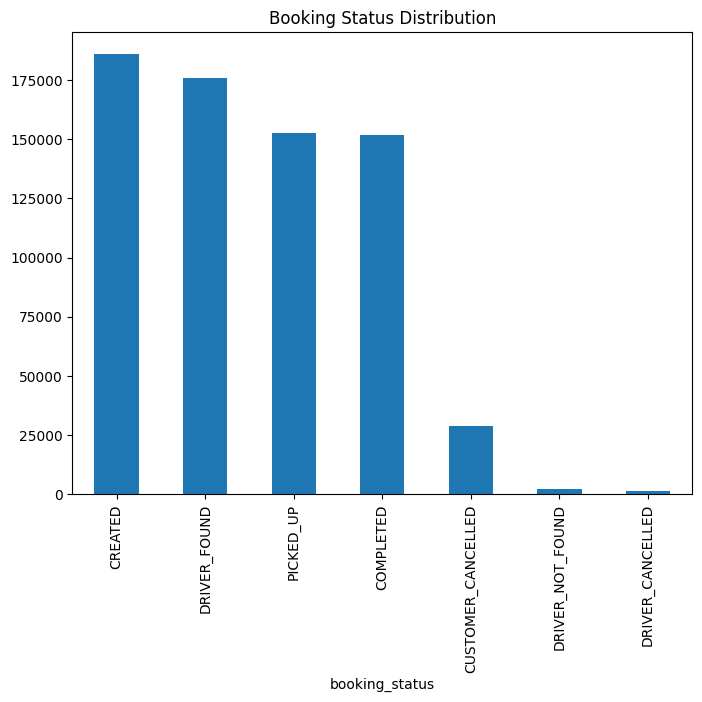

In [12]:
plt.figure(figsize=(8,6))
booking_log.booking_status.value_counts().plot(kind='bar')
plt.title('Booking Status Distribution')
plt.savefig(PROCESSED_DATA_DIR / 'booking_status_distribution.png')
plt.show()
plt.close()

In [13]:
# Participant log analysis
print("Participant Log Info")
print(participant_log.info())
print("\n")
print("Participant Log Missing Values")
print(participant_log.isna().sum())
print("\n")
print("Participant Log Duplicates")
print(participant_log.duplicated().sum())



Participant Log Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400230 entries, 0 to 400229
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_timestamp      400230 non-null  object 
 1   driver_id            400230 non-null  int64  
 2   participant_status   400230 non-null  object 
 3   order_id             400230 non-null  int64  
 4   experiment_key       400230 non-null  int64  
 5   driver_latitude      400230 non-null  float64
 6   driver_longitude     400230 non-null  float64
 7   driver_gps_accuracy  400230 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 24.4+ MB
None


Participant Log Missing Values
event_timestamp        0
driver_id              0
participant_status     0
order_id               0
experiment_key         0
driver_latitude        0
driver_longitude       0
driver_gps_accuracy    0
dtype: int64


Participant Log Duplicates
126


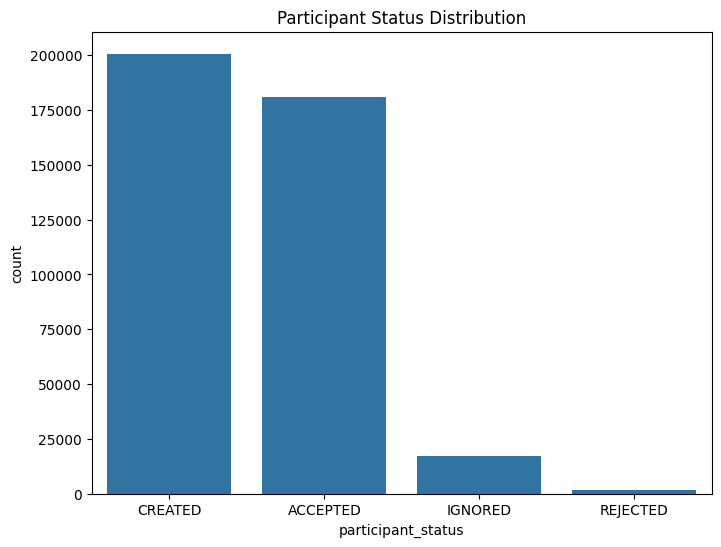

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=participant_log, x='participant_status')
plt.title('Participant Status Distribution')
plt.savefig(PROCESSED_DATA_DIR / 'participant_status_distribution.png')
plt.show()
plt.close()

In [15]:
# Test data analysis
print("Test Data Info")
print(test_data.info())
print("\n")
print("Test Data Missing Values")
print(test_data.isna().sum())

Test Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_timestamp      100000 non-null  object 
 1   order_id             100000 non-null  int64  
 2   customer_id          100000 non-null  int64  
 3   trip_distance        100000 non-null  float64
 4   pickup_latitude      100000 non-null  float64
 5   pickup_longitude     100000 non-null  float64
 6   driver_id            100000 non-null  int64  
 7   driver_latitude      100000 non-null  float64
 8   driver_longitude     100000 non-null  float64
 9   driver_gps_accuracy  100000 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 7.6+ MB
None


Test Data Missing Values
event_timestamp        0
order_id               0
customer_id            0
trip_distance          0
pickup_latitude        0
pickup_longitude       0
driver_id          

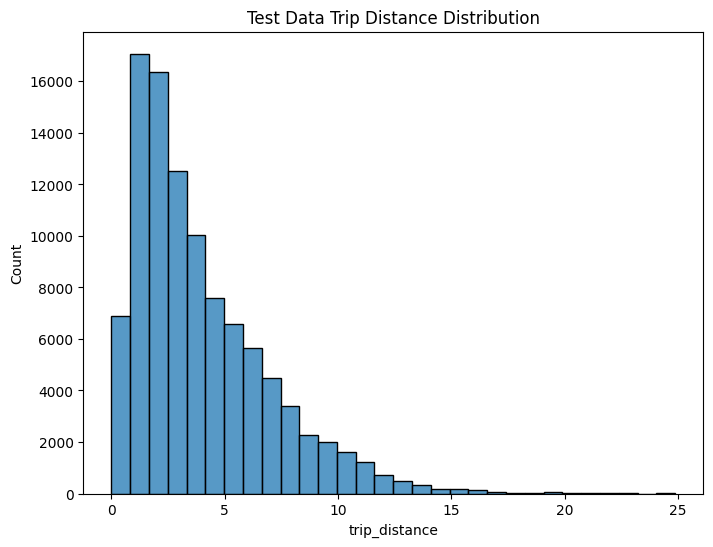

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(data=test_data, x='trip_distance', bins=30)
plt.title('Test Data Trip Distance Distribution')
plt.savefig(PROCESSED_DATA_DIR / 'test_trip_distance_distribution.png')
plt.show()
plt.close()

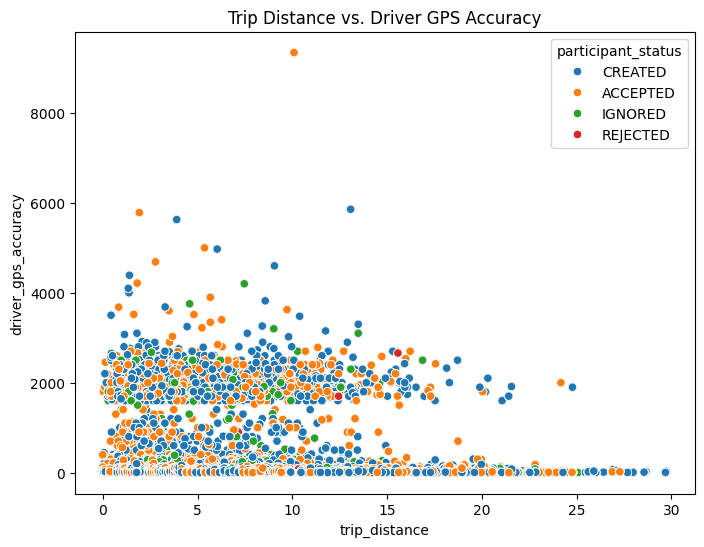

In [17]:
# Correlation analysis
merged = booking_log.merge(participant_log, on='order_id', how='left')
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged, x='trip_distance', y='driver_gps_accuracy', hue='participant_status')
plt.title('Trip Distance vs. Driver GPS Accuracy')
plt.savefig(PROCESSED_DATA_DIR / 'distance_vs_gps_accuracy.png')
plt.show()
plt.close()

## cleaning booking data

In [18]:
unique_columns = [
    "order_id",
    "event_timestamp",
    "booking_status",
    "customer_id",
    "driver_id",
    "trip_distance",
    "pickup_latitude",
    "pickup_longitude"
]

In [19]:
booking_df = booking_log[unique_columns].drop_duplicates()

In [20]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698233 entries, 0 to 699211
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          698233 non-null  int64  
 1   event_timestamp   698141 non-null  object 
 2   booking_status    698233 non-null  object 
 3   customer_id       698233 non-null  int64  
 4   driver_id         504523 non-null  float64
 5   trip_distance     698233 non-null  float64
 6   pickup_latitude   698233 non-null  float64
 7   pickup_longitude  698233 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 47.9+ MB


In [21]:
booking_df['event_timestamp'] = pd.to_datetime(booking_df['event_timestamp'], errors='coerce')
booking_df['driver_id'] = booking_df['driver_id'].fillna(-1).astype(int)
booking_df['pickup_latitude'] = booking_df['pickup_latitude'].fillna(booking_df['pickup_latitude'].mean())
booking_df['pickup_longitude'] = booking_df['pickup_longitude'].fillna(booking_df['pickup_longitude'].mean())
booking_df['trip_distance'] = booking_df['trip_distance'].fillna(booking_df['trip_distance'].mean())

In [22]:
print(f"Cleaned booking_df shape: {booking_df.shape}")

Cleaned booking_df shape: (698233, 8)


In [23]:
booking_df.columns.to_list()

['order_id',
 'event_timestamp',
 'booking_status',
 'customer_id',
 'driver_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude']

In [24]:
booking_df.head()

,order_id,event_timestamp,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
0,102254181112,2015-05-12 05:25:23.904000+00:00,CREATED,715281995014,-1,2.0,-2.998461,104.788077
1,102254181112,2015-05-12 05:25:24.670000+00:00,DRIVER_FOUND,715281995014,221172732473,2.0,-2.998461,104.788077
2,102254181112,2015-05-12 05:55:10.496544+00:00,COMPLETED,715281995014,221172732473,2.0,-2.998461,104.788077
3,105520285203,2015-05-12 05:29:37.305000+00:00,CREATED,957980952237,-1,2.0,-2.970621,104.756226
4,105520285203,2015-05-12 05:29:38.214000+00:00,DRIVER_FOUND,957980952237,527672421312,2.0,-2.970621,104.756226


## Clean participant data

In [25]:
participant_df = participant_log.drop_duplicates()

In [26]:
participant_df['event_timestamp'] = pd.to_datetime(participant_df['event_timestamp'], errors='coerce')
participant_df['driver_latitude'] = participant_df['driver_latitude'].fillna(participant_df['driver_latitude'].mean())
participant_df['driver_longitude'] = participant_df['driver_longitude'].fillna(participant_df['driver_longitude'].mean())
participant_df['driver_gps_accuracy'] = participant_df['driver_gps_accuracy'].fillna(participant_df['driver_gps_accuracy'].mean())

In [27]:
print(f"Cleaned participant_df shape: {participant_df.shape}")

Cleaned participant_df shape: (400104, 8)


In [28]:
participant_df.columns.to_list()

['event_timestamp',
 'driver_id',
 'participant_status',
 'order_id',
 'experiment_key',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy']

In [29]:
participant_df.head()

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
0,2015-05-18 11:45:19.519000+00:00,110283102582,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0
1,2015-05-18 11:45:29.800000+00:00,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.0
2,2015-05-11 10:35:57.021000+00:00,126346998414,CREATED,992080359113,941995970460,-2.966915,104.748040,2.0
3,2015-05-11 10:36:01.148000+00:00,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.0
4,2015-05-16 12:34:20.044000+00:00,199325048812,ACCEPTED,797723880713,197604093364,-3.014740,104.694647,2.0


## Merge Datasets

In [30]:
dataset = pd.merge(
    participant_df,
    booking_df,
    on=["order_id"],
    how="left",
    suffixes=('_participant', '_booking')
)

In [31]:
dataset.columns.to_list()

['event_timestamp_participant',
 'driver_id_participant',
 'participant_status',
 'order_id',
 'experiment_key',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy',
 'event_timestamp_booking',
 'booking_status',
 'customer_id',
 'driver_id_booking',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude']

In [32]:
#driver_id_booking as int
dataset['driver_id_booking'] = dataset['driver_id_booking'].astype(int)
dataset['driver_id_participant'] = dataset['driver_id_participant'].astype(int)

In [ ]:
dataset['driver_id'] = dataset['driver_id_participant'].fillna(dataset['driver_id_booking']).fillna(-1).astype(int)


In [31]:
dataset = dataset.drop(columns=['driver_id_participant', 'driver_id_booking'])

In [34]:
dataset.head()

,event_timestamp_participant,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp_booking,booking_status,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id
0,2015-05-18 11:45:19.519000+00:00,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18 11:45:03.958000+00:00,CREATED,786955815516,5.601,-2.980337,104.7612,110283102582
1,2015-05-18 11:45:19.519000+00:00,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18 11:45:30.076000+00:00,DRIVER_FOUND,786955815516,5.601,-2.980337,104.7612,110283102582
2,2015-05-18 11:45:19.519000+00:00,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18 11:52:13.997000+00:00,CUSTOMER_CANCELLED,786955815516,5.601,-2.980337,104.7612,110283102582
3,2015-05-18 11:45:29.800000+00:00,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18 11:45:03.958000+00:00,CREATED,786955815516,5.601,-2.980337,104.7612,110283102582
4,2015-05-18 11:45:29.800000+00:00,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18 11:45:30.076000+00:00,DRIVER_FOUND,786955815516,5.601,-2.980337,104.7612,110283102582


In [35]:
dataset['trip_distance'] = dataset['trip_distance'].fillna(dataset['trip_distance'].mean())
dataset['pickup_latitude'] = dataset['pickup_latitude'].fillna(dataset['pickup_latitude'].mean())
dataset['pickup_longitude'] = dataset['pickup_longitude'].fillna(dataset['pickup_longitude'].mean())


In [36]:
print(f"Merged dataset shape: {dataset.shape}")

Merged dataset shape: (1510833, 14)


In [37]:
print(f"Merged dataset columns: {dataset.columns.tolist()}")

Merged dataset columns: ['event_timestamp_participant', 'participant_status', 'order_id', 'experiment_key', 'driver_latitude', 'driver_longitude', 'driver_gps_accuracy', 'event_timestamp_booking', 'booking_status', 'customer_id', 'trip_distance', 'pickup_latitude', 'pickup_longitude', 'driver_id']


In [38]:
print(f"Missing driver_id values: {dataset['driver_id'].isna().sum()}")

Missing driver_id values: 0


In [ ]:
# target 
dataset['target'] = dataset['participant_status'].apply(lambda x:1 if x== "ACCEPTED" else 0)
dataset['target'] = dataset['target'].fillna(0)

dataset['target'].value_counts()

target
0    822697
1    688136
Name: count, dtype: int64

## Feature Engineering Driver distance

In [40]:
dataset["driver_distance"] = dataset.apply(
    lambda r: haversine(
        (r["driver_latitude"], r["driver_longitude"]),
        (r["pickup_latitude"], r["pickup_longitude"]),
    ) if pd.notna(r["driver_latitude"]) and pd.notna(r["pickup_latitude"]) else 0,
    axis=1,
)

# Feature engineering - event hour

In [41]:
dataset["event_hour"] = dataset["event_timestamp_participant"].apply(
    lambda x: pd.to_datetime(x).hour if pd.notna(x) else 0
)

<Axes: xlabel='event_hour'>

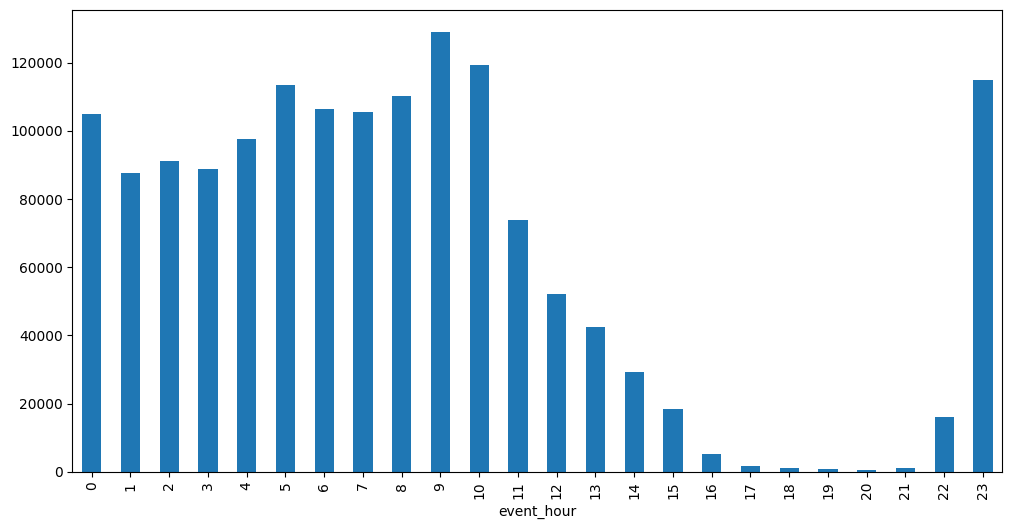

In [42]:
dataset['event_hour'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))

In [43]:
print(dataset.columns.to_list())

['event_timestamp_participant', 'participant_status', 'order_id', 'experiment_key', 'driver_latitude', 'driver_longitude', 'driver_gps_accuracy', 'event_timestamp_booking', 'booking_status', 'customer_id', 'trip_distance', 'pickup_latitude', 'pickup_longitude', 'driver_id', 'target', 'driver_distance', 'event_hour']


In [44]:
print(participant_df.columns)
print(booking_df.columns)

Index(['event_timestamp', 'driver_id', 'participant_status', 'order_id',
       'experiment_key', 'driver_latitude', 'driver_longitude',
       'driver_gps_accuracy'],
      dtype='object')
Index(['order_id', 'event_timestamp', 'booking_status', 'customer_id',
       'driver_id', 'trip_distance', 'pickup_latitude', 'pickup_longitude'],
      dtype='object')


# Feature engineering - driver historical completed bookings

In [46]:
dataset.columns.tolist()

['event_timestamp_participant',
 'participant_status',
 'order_id',
 'experiment_key',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy',
 'event_timestamp_booking',
 'booking_status',
 'customer_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude',
 'driver_id',
 'target',
 'driver_distance',
 'event_hour']

In [47]:
completed_bookings = dataset[dataset['booking_status'] == 'COMPLETED']


In [48]:
completed_bookings.columns.tolist()

['event_timestamp_participant',
 'participant_status',
 'order_id',
 'experiment_key',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy',
 'event_timestamp_booking',
 'booking_status',
 'customer_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude',
 'driver_id',
 'target',
 'driver_distance',
 'event_hour']

In [49]:
driver_counts = completed_bookings.groupby('driver_id').size().reset_index(name='historical_completed_bookings')

In [50]:
dataset = dataset.merge(driver_counts, on='driver_id', how='left')

In [51]:

dataset['historical_completed_bookings'] = dataset['historical_completed_bookings'].fillna(0)



# Feature engineering - Driver acceptance rate

In [52]:
acceptance_rate = dataset.groupby('driver_id')['target'].mean().reset_index(name='driver_acceptance_rate')

In [53]:
dataset = dataset.merge(acceptance_rate, on='driver_id', how='left')

In [ ]:
dataset['driver_acceptance_rate'] = dataset['driver_acceptance_rate'].fillna(dataset['driver_acceptance_rate'].mean())


2025-05-08 21:20:57,308 - INFO - Driver acceptance rate calculated


In [55]:
dataset.columns.to_list()

['event_timestamp_participant',
 'participant_status',
 'order_id',
 'experiment_key',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy',
 'event_timestamp_booking',
 'booking_status',
 'customer_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude',
 'driver_id',
 'target',
 'driver_distance',
 'event_hour',
 'historical_completed_bookings',
 'driver_acceptance_rate']

# Data processing - Split into train and test

In [56]:
train_data, test_data_split = train_test_split(dataset, test_size=0.2, random_state=42)

In [57]:
print(f"Train data shape: {train_data.shape}, Test data shape: {test_data_split.shape}")

Train data shape: (1208666, 19), Test data shape: (302167, 19)


In [58]:
test_data.columns.to_list()

['event_timestamp',
 'order_id',
 'customer_id',
 'trip_distance',
 'pickup_latitude',
 'pickup_longitude',
 'driver_id',
 'driver_latitude',
 'driver_longitude',
 'driver_gps_accuracy']

In [59]:
test_data['event_timestamp'] = pd.to_datetime(test_data['event_timestamp'], errors='coerce')

In [60]:

test_data['trip_distance'] = test_data['trip_distance'].fillna(train_data['trip_distance'].mean())
test_data['pickup_latitude'] = test_data['pickup_latitude'].fillna(train_data['pickup_latitude'].mean())
test_data['pickup_longitude'] = test_data['pickup_longitude'].fillna(train_data['pickup_longitude'].mean())
test_data['driver_latitude'] = test_data['driver_latitude'].fillna(train_data['driver_latitude'].mean())
test_data['driver_longitude'] = test_data['driver_longitude'].fillna(train_data['driver_longitude'].mean())
test_data['driver_gps_accuracy'] = test_data['driver_gps_accuracy'].fillna(train_data['driver_gps_accuracy'].mean())

In [61]:
test_data['driver_id'] = test_data['driver_id'].fillna(-1).astype(int)

In [62]:
test_data = test_data.rename(columns={'event_timestamp': 'event_timestamp_participant'})

# Feature engineering - Apply to test_data

In [63]:
test_data["driver_distance"] = test_data.apply(
    lambda r: haversine(
        (r["driver_latitude"], r["driver_longitude"]),
        (r["pickup_latitude"], r["pickup_longitude"]),
    ) if pd.notna(r["driver_latitude"]) and pd.notna(r["pickup_latitude"]) else 0,
    axis=1,
)

In [64]:
test_data["event_hour"] = test_data["event_timestamp_participant"].apply(
    lambda x: pd.to_datetime(x).hour if pd.notna(x) else 0
)

In [65]:
test_data = test_data.merge(driver_counts, on='driver_id', how='left')

In [67]:
test_data = test_data.merge(acceptance_rate, on='driver_id', how='left')
test_data['driver_acceptance_rate'] = test_data['driver_acceptance_rate'].fillna(train_data['driver_acceptance_rate'].mean())


In [70]:
store.put_processed("train_data.csv", train_data)
store.put_processed("test_data.csv", test_data)

# Classifier

In [72]:
class Classifier(ABC):
    @abstractmethod
    def train(self, *params) -> None:
        pass

    @abstractmethod
    def evaluate(self, *params) -> Dict[str, float]:
        pass

    @abstractmethod
    def predict(self, *params) -> np.ndarray:
        pass

In [73]:
class SklearnClassifier(Classifier):
    def __init__(self, estimator, features: List[str], target: str):
        self.clf = estimator
        self.features = features
        self.target = target

    def train(self, df_train: pd.DataFrame):
        logger.info(f"Training classifier with features: {self.features}")
        self.clf.fit(df_train[self.features].values, df_train[self.target].values)
        logger.info("Training completed")

    def evaluate(self, df_test: pd.DataFrame) -> Dict[str, float]:
        y_true = df_test[self.target].values
        y_pred = self.clf.predict(df_test[self.features].values)
        y_pred_proba = self.clf.predict_proba(df_test[self.features].values)[:, 1]
        metrics = {
            'roc_auc': roc_auc_score(y_true, y_pred_proba),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0)
        }
        logger.info(f"Evaluation metrics: {metrics}")
        return metrics

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        logger.info("Generating predictions")
        return self.clf.predict_proba(df[self.features].values)[:, 1]


In [ ]:
#features and target
features = ['driver_distance', 'event_hour', 'historical_completed_bookings', 'driver_acceptance_rate']
target = 'target'

In [75]:
rf_estimator = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model = SklearnClassifier(rf_estimator, features, target)
model.train(train_data)

2025-05-08 22:58:16,155 - INFO - Training classifier with features: ['driver_distance', 'event_hour', 'historical_completed_bookings', 'driver_acceptance_rate']
2025-05-08 23:01:01,930 - INFO - Training completed


In [76]:
# evaluate the model on the test set
metrics = model.evaluate(test_data_split)
print("Evaluation Metrics:", metrics)

2025-05-08 23:01:05,893 - INFO - Evaluation metrics: {'roc_auc': np.float64(0.5506952309277857), 'precision': 0.4454053201556093, 'recall': 0.12323725990734478, 'f1_score': 0.19305811111807364}


Evaluation Metrics: {'roc_auc': np.float64(0.5506952309277857), 'precision': 0.4454053201556093, 'recall': 0.12323725990734478, 'f1_score': 0.19305811111807364}


In [77]:
# Save the model and metrics
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

In [78]:
test_data['score'] = model.predict(test_data)


2025-05-08 23:01:40,799 - INFO - Generating predictions


In [79]:
def choose_best_driver(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby("order_id").agg({"driver_id": list, "score": list}).reset_index()
    df["best_driver"] = df.apply(
        lambda r: r["driver_id"][np.argmax(r["score"])] if r["score"] else -1, axis=1
    )
    df = df.drop(["driver_id", "score"], axis=1)
    df = df.rename(columns={"best_driver": "driver_id"})
    return df

In [80]:
    
selected_drivers = choose_best_driver(test_data)

In [81]:
selected_drivers

,order_id,driver_id
0,100042151807,493239186093
1,100081753505,816410658278
2,100161922318,857332913941
3,100241210016,225160660940
4,100257841517,918995571128
...,...,...
9995,898811959012,323654782752
9996,898830876614,764469437992
9997,898964332814,928925434799
9998,899096511800,793041821498


In [82]:
selected_drivers.to_csv('results.csv', index=False)
print("Predictions saved to 'results.csv'")

Predictions saved to 'results.csv'
